# Box Atlas, Hands only

In [1]:
#%load_ext autoreload
#%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from copy import copy
from pympc.geometry.polytope import Polytope
from pympc.dynamical_systems import DTAffineSystem, DTPWASystem, dare, moas_closed_loop
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController

Acronyms:
q -> position, v -> velocity, f -> contact force
b -> body, lh -> left hand, rh -> right hand, lf -> left foot, rf -> right foot
x -> horizontal axis, y -> vertical axis

State vector \in R^8:
[q_b_x, q_b_y, q_lh_x, q_lh_y, q_rh_x, q_rh_y, v_b_x, v_b_y]

Input vector \in R^10:
[v_lh_x, v_lh_y, v_rh_x, v_rh_y, f_lh_y, f_rh_y, f_lf_x, f_lf_y, f_rf_x, f_rf_y]

Numeric constants

In [3]:
# scalars
mass = 1.
stiffness = 100.
gravity = 10.
friction_coefficient = .5
t_s = .1
walls_distance = 1.

# position bounds

# body
q_b_min = np.array([[.3],[.3]])
q_b_max = np.array([[.7],[.7]])

# left hand (limits in the body frame)
q_lh_min = np.array([[.1],[-.2]])
q_lh_max = np.array([[.5],[.2]])

# right hand (limits in the body frame)
q_rh_min = np.array([[-.5],[-.2]])
q_rh_max = np.array([[-.1],[.2]])

# velocity bounds

# body
v_b_max = np.ones((2,1))
v_b_min = - v_b_max

# hands
v_h_max = np.ones((2,1))
v_h_min = - v_h_max

# force bounds

# left hand
max_penetration_lh = q_b_max[0,0] + q_lh_max[0,0] - walls_distance
f_lh_y_max = friction_coefficient * stiffness * max_penetration_lh
f_lh_y_min = - f_lh_y_max

# right hand
max_penetration_rh = - q_b_min[0,0] - q_rh_min[0,0]
f_rh_y_max = friction_coefficient * stiffness * max_penetration_rh
f_rh_y_min = - f_rh_y_max

# feet
f_f_y_max = 10. * mass * gravity
f_f_y_min = 0.
f_f_x_max = friction_coefficient * f_f_y_max
f_f_x_min = - f_f_x_max

# equilibrium point
x_eq = np. array([
    [.5], # q_b_x
    [.5], # q_b_y
    [.9], # q_lh_x
    [.6], # q_lh_y
    [.1], # q_rh_x
    [.6], # q_rh_y
    [0.], # v_b_x
    [0.], # v_b_y
    ])
u_eq = np.zeros((10,1))
u_eq[7,0] = mass * gravity / 2.
u_eq[9,0] = mass * gravity / 2.

Dynamics

In [4]:
# mode 0: no contacts
A_ct_0 = np.vstack((
    np.hstack((np.zeros((2, 6)), np.eye(2))),
    np.zeros((6, 8))
    ))
B_ct_0 = np.vstack((
    np.zeros((2, 10)),
    np.hstack((np.eye(4), np.zeros((4, 6)))),
    np.hstack((np.zeros((2, 6)), np.eye(2)/mass, np.eye(2)/mass)),
    ))
c_ct_0 = np.zeros((8,1))
c_ct_0[7,0] = - gravity
S_0 = DTAffineSystem.from_continuous(A_ct_0, B_ct_0, c_ct_0 + A_ct_0.dot(x_eq) + B_ct_0.dot(u_eq), t_s, 'explicit_euler')

# mode 1: left hand in contact
A_ct_1 = A_ct_0
A_ct_1[6,2] = -stiffness/mass
B_ct_1 = B_ct_0
B_ct_1[3,1] = 0.
B_ct_1[7,4] = 1./mass
c_ct_1 = c_ct_0
c_ct_1[6,0] = stiffness*walls_distance/mass
S_1 = DTAffineSystem.from_continuous(A_ct_1, B_ct_1, c_ct_1 + A_ct_1.dot(x_eq) + B_ct_1.dot(u_eq), t_s, 'explicit_euler')

# mode 2: right hand in contact
A_ct_2 = A_ct_0
A_ct_2[6,4] = -stiffness/mass
B_ct_2 = B_ct_0
B_ct_2[5,3] = 0.
B_ct_2[7,5] = 1./mass
c_ct_2 = c_ct_0
S_2 = DTAffineSystem.from_continuous(A_ct_2, B_ct_2, c_ct_2 + A_ct_2.dot(x_eq) + B_ct_1.dot(u_eq), t_s, 'explicit_euler')

# gather systems
S = [S_0, S_1, S_2]

Kinematic limits

In [5]:
selection_matrix = np.vstack((np.eye(2), -np.eye(2)))

# left hand
lhs = np.hstack((-selection_matrix, selection_matrix, np.zeros((4,4))))
rhs = np.vstack((q_lh_max, -q_lh_min))
X = Polytope(lhs, rhs)
X.add_lower_bounds(np.zeros((1,1)), [3])

# right hand
lhs = np.hstack((-selection_matrix, np.zeros((4,2)), selection_matrix, np.zeros((4,2))))
rhs = np.vstack((q_rh_max, -q_rh_min))
X.add_facets(lhs, rhs)
X.add_lower_bounds(np.zeros((1,1)), [5])

# body
X.add_bounds(q_b_min, q_b_max, [0,1])
X.add_bounds(v_b_min, v_b_max, [6,7])

Input limits

In [6]:
u_max = np.vstack((v_h_max, v_h_max, f_lh_y_max, f_rh_y_max, f_f_x_max, f_f_y_max, f_f_x_max, f_f_y_max))
u_min = np.vstack((v_h_min, v_h_min, f_lh_y_min, f_rh_y_min, f_f_x_min, f_f_y_min, f_f_x_min, f_f_y_min))
U = Polytope.from_bounds(u_min, u_max)

Mode indepenedent contraints

In [7]:
lhs = np.vstack((
    np.hstack((
        X.A,
        np.zeros((X.A.shape[0], U.A.shape[1]))
        )),
    np.hstack((
        np.zeros((U.A.shape[0], X.A.shape[1])),
        U.A
        ))
    ))
rhs = np.vstack((X.b, U.b))
D = Polytope(lhs, rhs)

Mode dependent constraints

In [8]:
# mode 0: no contacts
D_0 = copy(D)
D_0.add_upper_bounds(np.array([[walls_distance]]), [2])
D_0.add_lower_bounds(np.zeros((1,1)), [4])
D_0 = Polytope(D_0.A, D_0.b - D_0.A.dot(np.vstack((x_eq, u_eq))))
D_0.assemble()

# mode 1: left hand in contact
D_1 = copy(D)
D_1.add_lower_bounds(np.array([[walls_distance]]), [2])
D_1.add_lower_bounds(np.zeros((1,1)), [4])
lhs = np.zeros((2,18))
lhs[0,2] = - friction_coefficient * stiffness
lhs[0,12] = 1.
lhs[1,2] = - friction_coefficient * stiffness
lhs[1,12] = -1.
rhs = - np.ones((2,1)) * friction_coefficient * stiffness * walls_distance
D_1.add_facets(lhs, rhs)
D_1 = Polytope(D_1.A, D_1.b - D_1.A.dot(np.vstack((x_eq, u_eq))))
D_1.assemble()

# mode 2: right hand in contact
D_2 = copy(D)
D_2.add_upper_bounds(np.array([[walls_distance]]), [2])
D_2.add_upper_bounds(np.zeros((1,1)), [4])
lhs = np.zeros((2,18))
lhs[0,4] = friction_coefficient * stiffness
lhs[0,13] = 1.
lhs[1,4] = friction_coefficient * stiffness
lhs[1,13] = -1.
rhs = np.zeros((2,1))
D_2.add_facets(lhs, rhs)
D_2 = Polytope(D_2.A, D_2.b - D_2.A.dot(np.vstack((x_eq, u_eq))))
D_2.assemble()

# gather domains
D = [D_0, D_1, D_2]

PWA system

In [9]:
pwa_sys = DTPWASystem(S, D)

In [10]:
# controller parameters
N = 10
Q = np.eye(8)
R = np.eye(10)
objective_norm = 'two'

# terminal set and cost
terminal_mode = 0
P, K = dare(S[terminal_mode].A, S[terminal_mode].B, Q, R)
X_N = moas_closed_loop(S[terminal_mode].A, S[terminal_mode].B, K, D[terminal_mode])

#X_N = Polytope.from_bounds(-np.ones((8,1))*.05, np.ones((8,1))*.05)
#X_N.assemble()

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

Computation of MOAS started... MOAS found.
MOAS facets are 270, removing redundant ones... redundant factes removed, MOAS facets are 136.


We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [11]:
N_sim = 100
x_0 = np.zeros((8,1))
x_0[0,0] = .1 # q_b_x
x_0[6,0] = .6 # v_b_x
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    x_next = pwa_sys.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [pwa_sys.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)

We can use the plot functions to visualize the time evolution of the system.

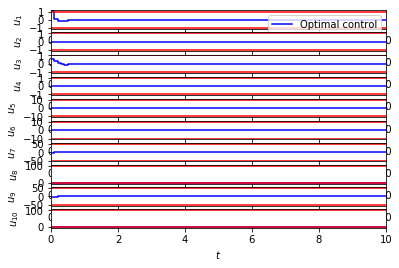

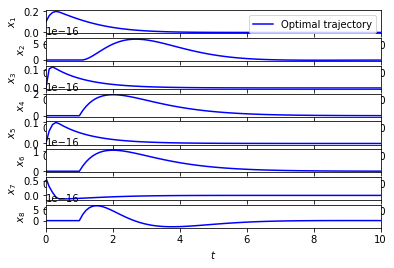

In [18]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s)
plt.show()